# Model Evaluation
**Author**: Johannes S. Fischer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from sklearn import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from model import get_base_model
from dataloader import load_FERplus_targetvector, load_RAF_targetvector
from utils import preprocess_fer, preprocess_raf

In [2]:
# function to turn imagedatagenerator set into tensors
def get_tensors(datagen):
    datagen.reset()
    
    X, Y = [], []
    batch_idx = 0
    while batch_idx <= datagen.batch_index:
        data = datagen.next()
        if len(X) == 0:
            X.append(data[0])
            X = np.array(np.squeeze(X))

            Y.append(data[1])
            Y = np.array(np.squeeze(Y))
        else:
            X = np.concatenate((X, data[0]), axis=0)
            Y = np.concatenate((Y, data[1]), axis=0)
        batch_idx += 1

    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

# Load Model

In [3]:
def vec2label(onehot_vec, emotion_labels):
    major_vote = np.argmax(onehot_vec)
    return emotion_labels[major_vote]

IMG_SHAPE = (100, 100, 3)

models = {
    'raf': {
        'name': 'RAF'
    },
    'fer': {
        'name': 'FER'
    }
}

### RAF

In [4]:
LABELS_RAF = ['surprise', 'fear', 'disgust', 'happiness', 'sadness', 'anger', 'neutral']

# model
model_name = 'RAF_0124-1008_weights.h5'
model_raf = get_base_model(IMG_SHAPE)
model_raf.add(tf.keras.layers.Dense(7, activation='softmax', name="softmax"))
model_raf.load_weights('./models/' + model_name)

model_raf.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

models['raf']['model'] = model_raf
models['raf']['labels'] = LABELS_RAF
models['raf']['preprocess'] = preprocess_raf

### FER+

In [5]:
LABELS_FER = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']

# model
model_name = 'FERplus_0124-1040_weights.h5'
model_fer = get_base_model(IMG_SHAPE)
model_fer.add(tf.keras.layers.Dense(7, activation='softmax', name="softmax"))
model_fer.load_weights('./models/' + model_name)

model_fer.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

models['fer']['model'] = model_fer
models['fer']['labels'] = LABELS_FER
models['fer']['preprocess'] = preprocess_fer

<br></br>

----------------

# Data

### RAF-DB

In [6]:
%%time
# RAF-DB data
train_raf, val_raf, test_raf = load_RAF_targetvector('./data/RAF/',
                                                     target_img_size=IMG_SHAPE[:2],
                                                     batch_size=64,
                                                     preprocessing_function=preprocess_raf)

Splitting test dataset into stratified validation and test set
Training
- (12271, 100, 100, 3) 
- (12271, 7)
Validation
- (1534, 100, 100, 3) 
- (1534, 7)
Testing
- (1534, 100, 100, 3) 
- (1534, 7)
Wall time: 14.3 s


### FER+

In [7]:
%%time
# FERplus data
train_fer, val_fer, test_fer = load_FERplus_targetvector('./data/ferplus2013/',
                                                         target_img_size=IMG_SHAPE[:2],
                                                         batch_size=64,
                                                         preprocessing_function=preprocess_fer)

Training
- (28557, 100, 100, 3) 
- (28557, 7)
Validation
- (3573, 100, 100, 3) 
- (3573, 7)
Testing
- (3579, 100, 100, 3) 
- (3579, 7)
Wall time: 56.8 s


<br></br>

----------------

# RAF-DB model

In [8]:
model = models['raf']
data_test = test_raf
data_val = val_raf

### Accuracies

In [9]:
# get tensors of test dataset
X, Y = get_tensors(data_test)
Y_logits = np.argmax(Y, axis=1)

preds = model['model'].predict(X)

Yhat = np.argmax(preds, axis=1)

print("Test Accuracy:\t{:.2f}%".format(100*(Y_logits == Yhat).sum() / Yhat.size))
print("Metrics:\n", metrics.classification_report(y_true=Y_logits, y_pred=Yhat, target_names=model['labels']))

Test Accuracy:	82.92%
Metrics:
               precision    recall  f1-score   support

    surprise       0.89      0.76      0.82       164
        fear       0.85      0.62      0.72        37
     disgust       0.81      0.28      0.41        80
   happiness       0.95      0.90      0.92       593
     sadness       0.82      0.80      0.81       239
       anger       0.87      0.75      0.81        81
     neutral       0.66      0.93      0.77       340

    accuracy                           0.83      1534
   macro avg       0.84      0.72      0.75      1534
weighted avg       0.85      0.83      0.82      1534



In [10]:
# validation accuracy
model['val'] = {}
model['val']['loss'], model['val']['acc'] = model['model'].evaluate(data_val)

print(f"\n-- Validation {model['name']}")
print("Accuracy:\t%.2f%%" % (model['val']['acc'] * 100))
print("Loss:\t\t%.4f" % (model['val']['loss']))

24/24 [==============================] - 4s 96ms/step - loss: 0.9054 - accuracy: 0.8279 0s - l

-- Validation RAF
Accuracy:	82.79%
Loss:		0.9054


In [11]:
# test accuracy for RAF-DB model
model['test'] = {}
model['test']['loss'], model['test']['acc'] = model['model'].evaluate(data_test)

print(f"\n-- Test {model['name']}")
print("Accuracy:\t%.2f%%" % (model['test']['acc'] * 100))
print("Loss:\t\t%.4f" % (model['test']['loss']))

24/24 [==============================] - 2s 68ms/step - loss: 0.8892 - accuracy: 0.8292 0s - loss: 0.8892 - accuracy: 0.82

-- Test RAF
Accuracy:	82.92%
Loss:		0.8892


### Confusion matrix

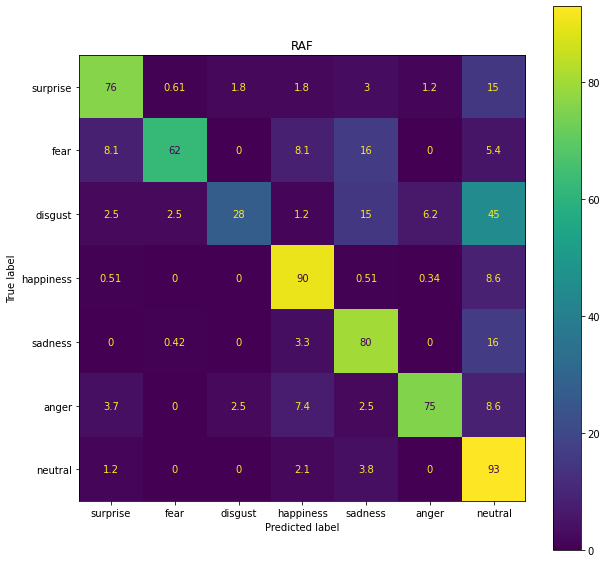

In [12]:
conf_matrix = metrics.confusion_matrix(Y_logits, Yhat, normalize='true')
disp = metrics.ConfusionMatrixDisplay(conf_matrix*100, display_labels=model['labels'])
plt.figure(figsize=(10,10))
ax = plt.axes()
disp.plot(ax=ax)
plt.title(model['name'])
plt.savefig('./conf-matrix-{}.png'.format(model['name']), dpi=300, bbox_inches='tight')
plt.show()

<br></br>

----------------

# FER+ model

In [13]:
model = models['fer']
data_test = test_fer
data_val = val_fer

### Accuracies

In [14]:
# get tensors of test dataset
X, Y = get_tensors(data_test)
Y_logits = np.argmax(Y, axis=1)

preds = model['model'].predict(X)

Yhat = np.argmax(preds, axis=1)

print("Test Accuracy:\t{:.2f}%".format(100*(Y_logits == Yhat).sum() / Yhat.size))
print("Metrics:\n", metrics.classification_report(y_true=Y_logits, y_pred=Yhat, target_names=model['labels']))

Test Accuracy:	83.77%
Metrics:
               precision    recall  f1-score   support

     neutral       0.85      0.86      0.85      1359
   happiness       0.90      0.94      0.92       900
    surprise       0.85      0.89      0.87       461
     sadness       0.70      0.65      0.67       423
       anger       0.79      0.78      0.79       322
     disgust       0.67      0.31      0.42        39
        fear       0.72      0.52      0.60        75

    accuracy                           0.84      3579
   macro avg       0.78      0.71      0.73      3579
weighted avg       0.83      0.84      0.83      3579



In [15]:
# validation accuracy
model['val'] = {}
model['val']['loss'], model['val']['acc'] = model['model'].evaluate(data_val)

print(f"\n-- Validation {model['name']}")
print("Accuracy:\t%.2f%%" % (model['val']['acc'] * 100))
print("Loss:\t\t%.4f" % (model['val']['loss']))

56/56 [==============================] - 5s 75ms/step - loss: 0.7637 - accuracy: 0.8421

-- Validation FER
Accuracy:	84.21%
Loss:		0.7637


In [16]:
# test accuracy for FERplus model
model['test'] = {}
model['test']['loss'], model['test']['acc'] = model['model'].evaluate(data_test)

print(f"\n-- Test {model['name']}")
print("Accuracy:\t%.2f%%" % (model['test']['acc'] * 100))
print("Loss:\t\t%.4f" % (model['test']['loss']))

56/56 [==============================] - 4s 76ms/step - loss: 0.7295 - accuracy: 0.8377

-- Test FER
Accuracy:	83.77%
Loss:		0.7295


### Confusion matrix

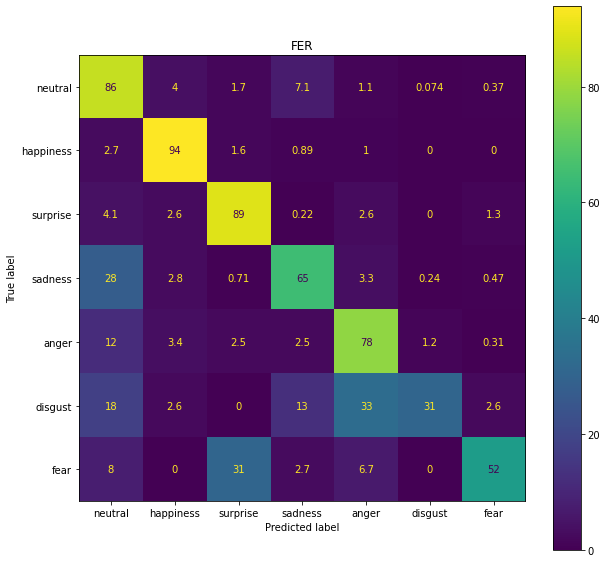

In [17]:
conf_matrix = metrics.confusion_matrix(Y_logits, Yhat, normalize='true')
disp = metrics.ConfusionMatrixDisplay(conf_matrix*100, display_labels=model['labels'])
plt.figure(figsize=(10,10))
ax = plt.axes()
disp.plot(ax=ax)
plt.title(model['name'])
plt.savefig('./conf-matrix-{}.png'.format(model['name']), dpi=300, bbox_inches='tight')
plt.show()

---